# BARRA <> DEA example notebook

This is a prototype notebook demonstrating the use of BARRA reanalysis data, specifically
the BARRA-R^1 'accum_prcp'^2 variable.

To be able to execute this notebook, you will need to have completed a "licence schedule" outlining
the usage rights to BARRA data, as well as requesting access to the NCI project 'ma05'.

1 - BARRA domain representing Australian continent <br />
2 - hourly accumulated precipitation including rainfall and snowfall

For more information on BARRA and the data used in this notebook, please see:

In [64]:
import datacube
import rasterio
import time
import os
import numpy as np
from datacube.helpers import write_geotiff
from matplotlib import pyplot
from IPython.display import Image

import xarray as xr
import dea_plotting
import matplotlib.pyplot as plt

## Before loading BARRA data...

In [65]:
# you will need a datacube confing:
config = {
    'db_hostname': 'agdcdev-db.nci.org.au',
    'db_port': 6432,
    'db_database': 'dg6911'
}
dc = datacube.Datacube(config=config)

In [66]:
#roughly Australia
query = {}


## Querying BARRA data

In [71]:
# this paricular BARRA variable has hourly time steps

barra_datasets = dc.find_datasets(product='barra_sy_fc_spec_vwnd10m',time='2019')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='barra_sy_fc_spec_av_accum_ls_prcp',time='1990-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='barra_sy_fc_spec_av_accum_ls_prcp',time='1990-01-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='barra_sy_fc_spec_av_accum_ls_prcp',time='1990-01-01T00:00:00.0000Z')
print(len(barra_datasets))

1416
744
24
1


In [9]:
barra_sy_fc_spec_av_accum_ls_prcp = dc.load(product='barra_sy_fc_spec_av_accum_ls_prcp',
                     time='1991-01-01T00:00:00.0000Z', **query)

In [10]:
barra_sy_fc_spec_av_accum_ls_prcp

<xarray.Dataset>
Dimensions:        (latitude: 742, longitude: 594, time: 1)
Coordinates:
  * time           (time) datetime64[ns] 1991-01-01T00:29:59.999999
  * latitude       (latitude) float64 -38.01 -37.99 -37.98 ... -28.02 -28.0
  * longitude      (longitude) float64 147.0 147.0 147.0 ... 155.0 155.0 155.0
Data variables:
    accum_ls_prcp  (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    crs:      GEOGCS["unknown",DATUM["unknown",SPHEROID["Sphere",6371229,0]],...

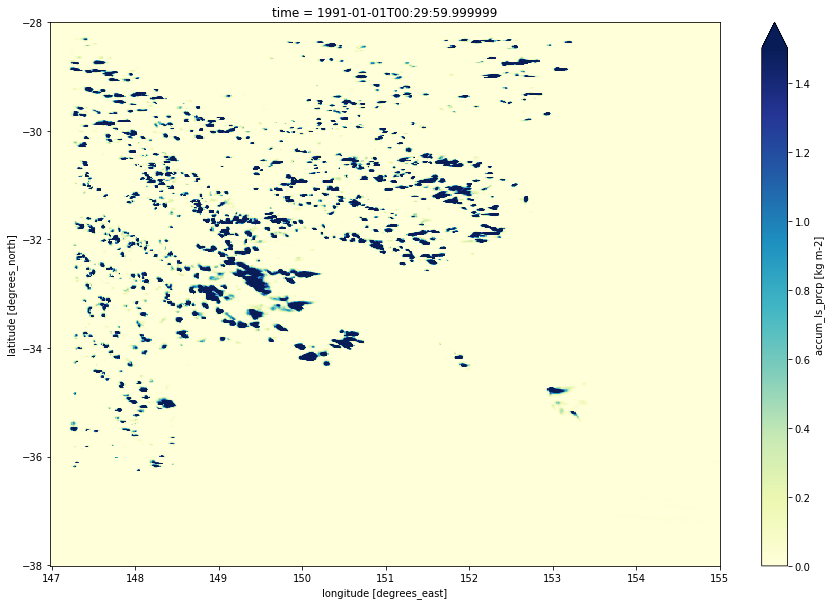

In [11]:
barra_sy_fc_spec_av_accum_ls_prcp['accum_ls_prcp'].squeeze().plot.imshow(cmap='YlGnBu', robust=True, size=10, vmin=0, vmax=1.5)

## Producing summaries

In [ ]:
%time  av_sfc_temp = dc.load(product='av_sfc_temp', time='1990-01-01', **query)

In [ ]:
maximum_temp = av_sfc_temp['av_sfc_temp'].max(dim='time')

In [ ]:
maximum_temp.plot.imshow(cmap='RdYlBu_r', size=10, robust=True)

In [ ]:
minimum_temp = av_sfc_temp['av_sfc_temp'].min(dim='time')

In [ ]:
minimum_temp.plot.imshow(cmap='RdYlBu_r', size=10, robust=True)

In [7]:
def flip_barra_data(source_dataset, target_variable='accum_ls_prcp'):
    temp_dataarray = source_dataset[target_variable].reindex(latitude=source_dataset[target_variable].latitude[::-1])
    target_dataset = temp_dataarray.to_dataset()
    target_dataset.attrs = temp_dataarray.attrs
    return target_dataset

## Load BARRA faster using DASK

In [4]:
import dask
import dask.distributed

client = dask.distributed.Client(n_workers=8,
                                 threads_per_worker=1,
                                 memory_limit='3G',
                                 ip='127.0.0.1')
client

<Client: 'tcp://127.0.0.1:42334' processes=8 threads=8, memory=24.00 GB>

In [60]:
barra_sy_fc_spec_av_accum_ls_prcp = dc.load(product='barra_sy_fc_spec_av_accum_ls_prcp',
             dask_chunks={'time':6},
               time='2006-06-06', **query)
barra_sy_fc_spec_av_accum_ls_prcp.load()

<xarray.Dataset>
Dimensions:        (latitude: 742, longitude: 594, time: 24)
Coordinates:
  * time           (time) datetime64[ns] 2006-06-06T00:29:59.999999 ... 2006-06-06T23:29:59.999999
  * latitude       (latitude) float64 -38.01 -37.99 -37.98 ... -28.02 -28.0
  * longitude      (longitude) float64 147.0 147.0 147.0 ... 155.0 155.0 155.0
Data variables:
    accum_ls_prcp  (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0
Attributes:
    crs:      GEOGCS["unknown",DATUM["unknown",SPHEROID["Sphere",6371229,0]],...

In [61]:
loaded_barra_sy_fc_spec_av_accum_ls_prcp = barra_sy_fc_spec_av_accum_ls_prcp

In [62]:
barra_sy_fc_spec_av_accum_ls_prcp = flip_barra_data(loaded_barra_sy_fc_spec_av_accum_ls_prcp)

Generating 24 frame animation
    Exporting animation to sy_rain.gif


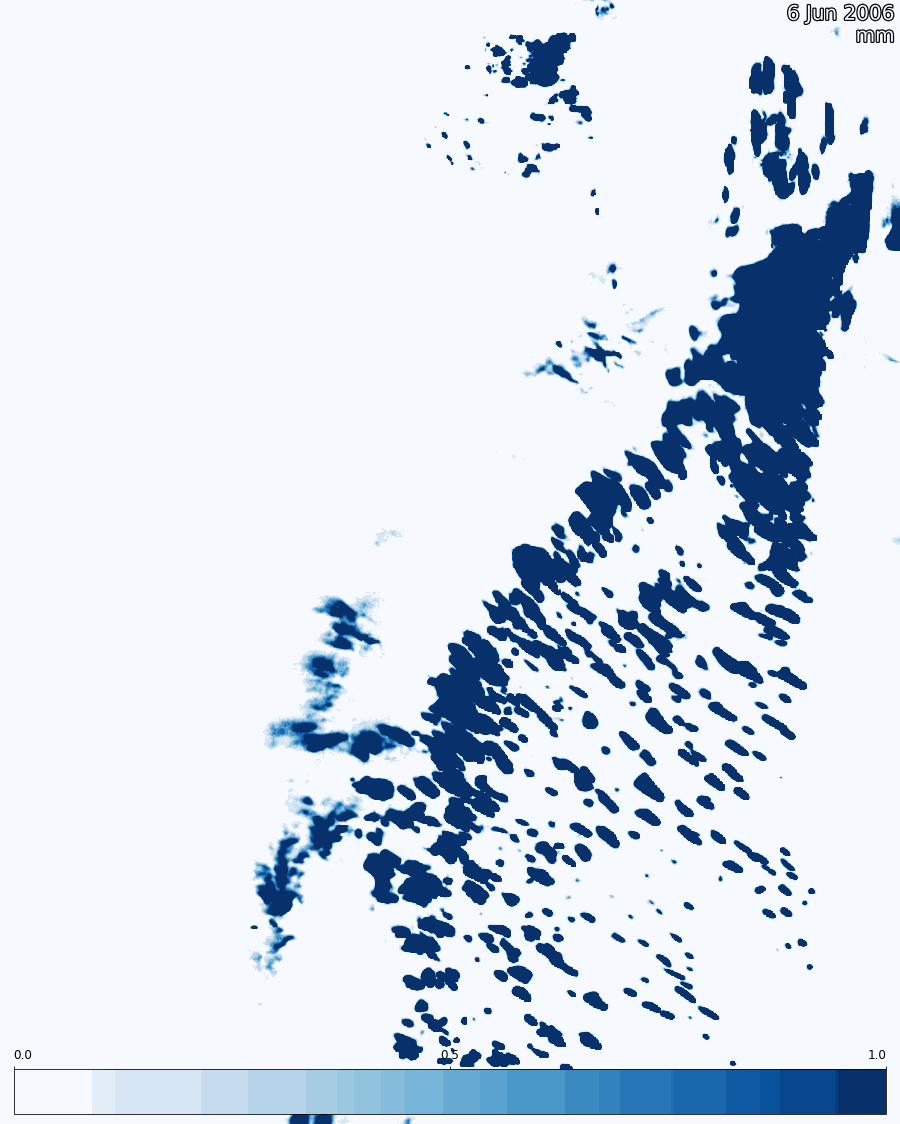

In [72]:
dea_plotting.animated_timeseries(ds=barra_sy_fc_spec_av_accum_ls_prcp, output_path='sy_rain.gif',
                                width_pixels=900,
                                bands=['accum_ls_prcp'],
                                title='mm',
                                interval=200,
                                x_dim='longitude',
                                y_dim='latitude',
                                time_dim='time',
                                onebandplot_kwargs={'cmap':'Blues','vmin':0, 'vmax':1})
# Plot animated gif
plt.close()
Image(filename='sy_rain.gif')